# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

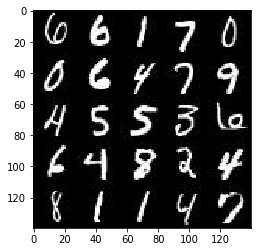

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

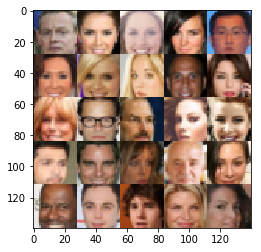

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real') 
    
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

    return input_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
       
        images_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        images_1 = tf.maximum(alpha * images_1, images_1)
        
        images_1 = tf.layers.conv2d(images_1, 128, 5, strides=2, padding='same',
                                    kernel_initializer=tf.contrib.layers.xavier_initializer())
        images_1 = tf.layers.batch_normalization(images_1, training=True)
        images_1 = tf.maximum(alpha * images_1, images_1)

        images_1 = tf.layers.conv2d(images_1, 256, 5, strides=2, padding='same',
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        images_1 = tf.layers.batch_normalization(images_1, training=True)
        images_1 = tf.maximum(alpha * images_1, images_1)

        #Flatten it
        images_1 = tf.reshape(images_1, (-1, 4*4*256))
        logits = tf.layers.dense(images_1, 1)
        out = tf.sigmoid(logits)
      
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):

        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x1 = tf.layers.conv2d_transpose(x1, 64, 5, strides=1, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        logits = tf.layers.conv2d_transpose(x1, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    alpha=0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)  
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   
    # TODO: Build Model
    samples = []
    losses = []
    count = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    time_begin_total = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                time_begin_batch = time.time()
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if count % 50 == 0:
                    print("count: {}".format(count))
                
                if count % 100 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
            
                    print("Epoch {}...".format(epoch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Batch Duration: {:.4f}".format(time.time() - time_begin_batch))    

                if count % 200 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

                count = count + 1
                
    print("Total Duration: {:.4f}".format(time.time() - time_begin_total))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size =  16 # (#8) 32 (#4) 64 (#2) 128
z_dim =  100 # (#7) 50
learning_rate = 0.0005 # (#9) 0.0001  (#5) 0.0005 (#3) 0.001 (#1) 0.0001
beta1 = 0.1 # (#6) 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

count: 0
Epoch 0... Discriminator Loss: 8.1500... Generator Loss: 0.0008 Batch Duration: 1.2913


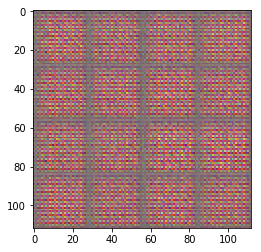

count: 50
count: 100
Epoch 0... Discriminator Loss: 2.6467... Generator Loss: 5.4750 Batch Duration: 0.1125
count: 150
count: 200
Epoch 0... Discriminator Loss: 1.6684... Generator Loss: 0.6148 Batch Duration: 0.1127


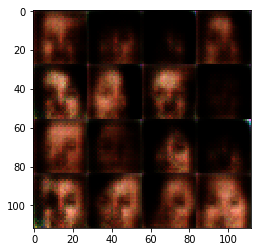

count: 250
count: 300
Epoch 0... Discriminator Loss: 1.3786... Generator Loss: 0.5679 Batch Duration: 0.1140
count: 350
count: 400
Epoch 0... Discriminator Loss: 1.8591... Generator Loss: 0.6456 Batch Duration: 0.1120


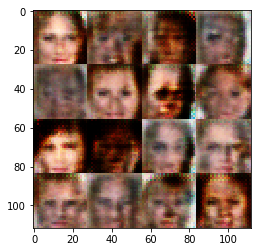

count: 450
count: 500
Epoch 0... Discriminator Loss: 1.2410... Generator Loss: 0.8041 Batch Duration: 0.1147
count: 550
count: 600
Epoch 0... Discriminator Loss: 1.4208... Generator Loss: 0.7716 Batch Duration: 0.1141


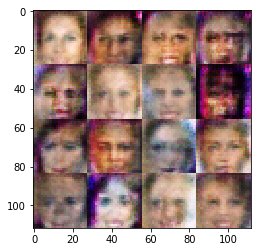

count: 650
count: 700
Epoch 0... Discriminator Loss: 1.3457... Generator Loss: 0.8178 Batch Duration: 0.1148
count: 750
count: 800
Epoch 0... Discriminator Loss: 1.3257... Generator Loss: 0.6899 Batch Duration: 0.1138


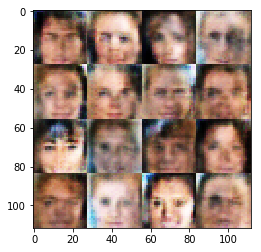

count: 850
count: 900
Epoch 0... Discriminator Loss: 1.5190... Generator Loss: 0.5401 Batch Duration: 0.1149
count: 950
count: 1000
Epoch 0... Discriminator Loss: 1.3501... Generator Loss: 0.7983 Batch Duration: 0.1154


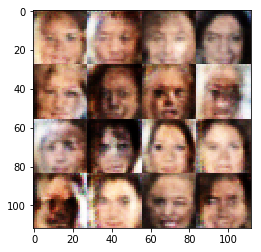

count: 1050
count: 1100
Epoch 0... Discriminator Loss: 1.3375... Generator Loss: 0.7265 Batch Duration: 0.1146
count: 1150
count: 1200
Epoch 0... Discriminator Loss: 1.4204... Generator Loss: 0.7369 Batch Duration: 0.1146


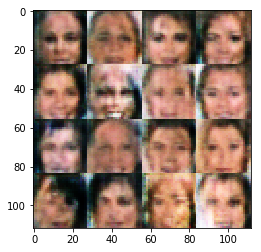

count: 1250
count: 1300
Epoch 0... Discriminator Loss: 1.3617... Generator Loss: 0.7325 Batch Duration: 0.1157
count: 1350
count: 1400
Epoch 0... Discriminator Loss: 1.3549... Generator Loss: 0.6876 Batch Duration: 0.1132


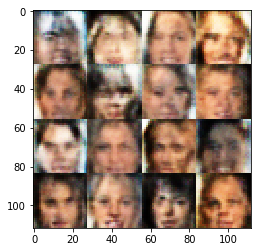

count: 1450
count: 1500
Epoch 0... Discriminator Loss: 1.4051... Generator Loss: 0.7954 Batch Duration: 0.1125
count: 1550
count: 1600
Epoch 0... Discriminator Loss: 1.4107... Generator Loss: 0.7077 Batch Duration: 0.1128


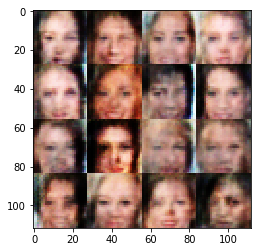

count: 1650
count: 1700
Epoch 0... Discriminator Loss: 1.3739... Generator Loss: 0.6830 Batch Duration: 0.1135
count: 1750
count: 1800
Epoch 0... Discriminator Loss: 1.3835... Generator Loss: 0.6807 Batch Duration: 0.1140


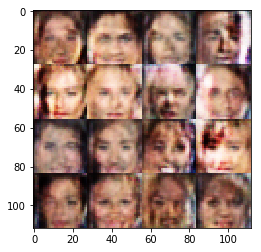

count: 1850
count: 1900
Epoch 0... Discriminator Loss: 1.4451... Generator Loss: 0.7252 Batch Duration: 0.1131
count: 1950
count: 2000
Epoch 0... Discriminator Loss: 1.3677... Generator Loss: 0.8440 Batch Duration: 0.1145


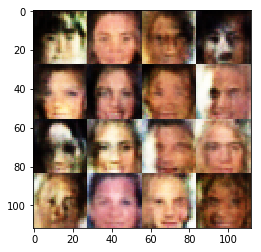

count: 2050
count: 2100
Epoch 0... Discriminator Loss: 1.3109... Generator Loss: 0.6968 Batch Duration: 0.1134
count: 2150
count: 2200
Epoch 0... Discriminator Loss: 1.3566... Generator Loss: 0.6945 Batch Duration: 0.1119


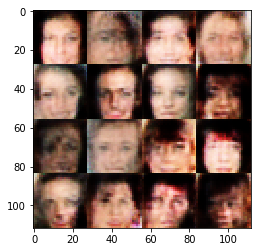

count: 2250
count: 2300
Epoch 0... Discriminator Loss: 1.5048... Generator Loss: 0.6779 Batch Duration: 0.1126
count: 2350
count: 2400
Epoch 0... Discriminator Loss: 1.4025... Generator Loss: 0.7638 Batch Duration: 0.1139


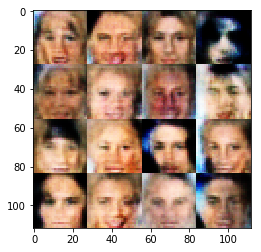

count: 2450
count: 2500
Epoch 0... Discriminator Loss: 1.2329... Generator Loss: 0.9204 Batch Duration: 0.1146
count: 2550
count: 2600
Epoch 0... Discriminator Loss: 1.7481... Generator Loss: 0.3815 Batch Duration: 0.1145


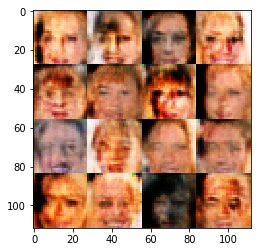

count: 2650
count: 2700
Epoch 0... Discriminator Loss: 1.3970... Generator Loss: 0.6883 Batch Duration: 0.1123
count: 2750
count: 2800
Epoch 0... Discriminator Loss: 1.4442... Generator Loss: 0.5517 Batch Duration: 0.1133


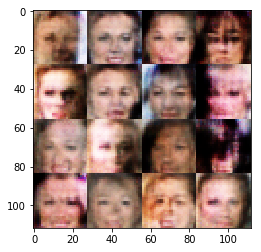

count: 2850
count: 2900
Epoch 0... Discriminator Loss: 1.4439... Generator Loss: 0.7568 Batch Duration: 0.1115
count: 2950
count: 3000
Epoch 0... Discriminator Loss: 1.3411... Generator Loss: 0.8318 Batch Duration: 0.1141


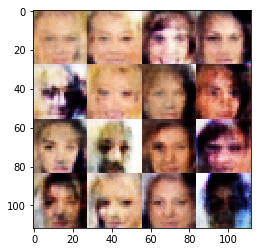

count: 3050
count: 3100
Epoch 0... Discriminator Loss: 1.4062... Generator Loss: 0.7781 Batch Duration: 0.1140
count: 3150
count: 3200
Epoch 0... Discriminator Loss: 1.4124... Generator Loss: 0.7164 Batch Duration: 0.1134


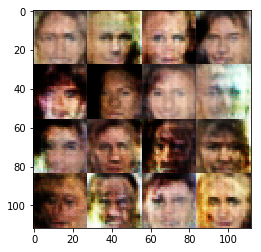

count: 3250
count: 3300
Epoch 0... Discriminator Loss: 1.3933... Generator Loss: 0.6168 Batch Duration: 0.1123
count: 3350
count: 3400
Epoch 0... Discriminator Loss: 1.3580... Generator Loss: 0.6332 Batch Duration: 0.1134


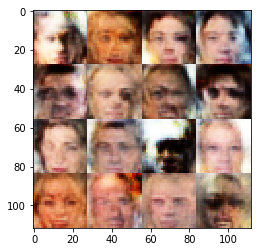

count: 3450
count: 3500
Epoch 0... Discriminator Loss: 1.2476... Generator Loss: 1.0686 Batch Duration: 0.1130
count: 3550
count: 3600
Epoch 0... Discriminator Loss: 1.1427... Generator Loss: 0.9048 Batch Duration: 0.1127


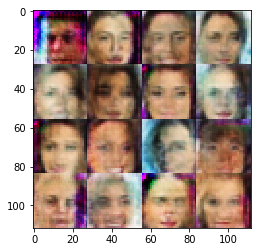

count: 3650
count: 3700
Epoch 0... Discriminator Loss: 1.4347... Generator Loss: 0.7347 Batch Duration: 0.1124
count: 3750
count: 3800
Epoch 0... Discriminator Loss: 1.3056... Generator Loss: 0.7197 Batch Duration: 0.1123


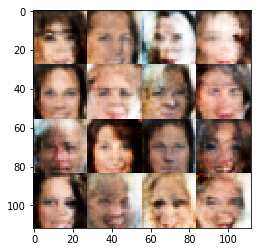

count: 3850
count: 3900
Epoch 0... Discriminator Loss: 1.3462... Generator Loss: 0.6686 Batch Duration: 0.1136
count: 3950
count: 4000
Epoch 0... Discriminator Loss: 1.3966... Generator Loss: 0.7464 Batch Duration: 0.1123


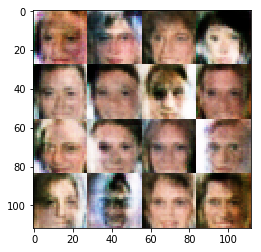

count: 4050
count: 4100
Epoch 0... Discriminator Loss: 1.4016... Generator Loss: 0.6881 Batch Duration: 0.1153
count: 4150
count: 4200
Epoch 0... Discriminator Loss: 1.3865... Generator Loss: 0.6727 Batch Duration: 0.1134


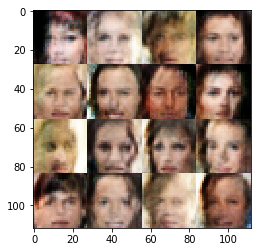

count: 4250
count: 4300
Epoch 0... Discriminator Loss: 1.3199... Generator Loss: 0.6790 Batch Duration: 0.1141
count: 4350
count: 4400
Epoch 0... Discriminator Loss: 1.3286... Generator Loss: 0.8286 Batch Duration: 0.1143


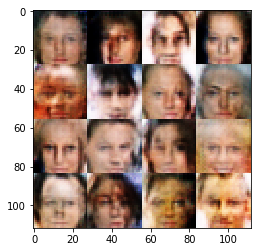

count: 4450
count: 4500
Epoch 0... Discriminator Loss: 1.3704... Generator Loss: 0.6946 Batch Duration: 0.1131
count: 4550
count: 4600
Epoch 0... Discriminator Loss: 1.1459... Generator Loss: 0.8629 Batch Duration: 0.1123


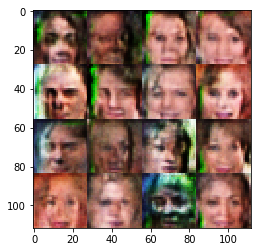

count: 4650
count: 4700
Epoch 0... Discriminator Loss: 1.3444... Generator Loss: 0.7512 Batch Duration: 0.1125
count: 4750
count: 4800
Epoch 0... Discriminator Loss: 1.2519... Generator Loss: 0.9584 Batch Duration: 0.1128


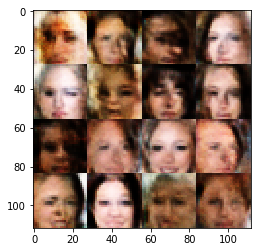

count: 4850
count: 4900
Epoch 0... Discriminator Loss: 1.4330... Generator Loss: 0.7542 Batch Duration: 0.1124
count: 4950
count: 5000
Epoch 0... Discriminator Loss: 1.4389... Generator Loss: 0.6419 Batch Duration: 0.1122


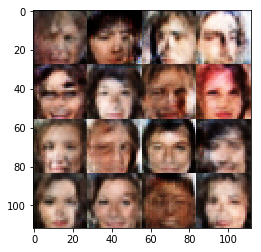

count: 5050
count: 5100
Epoch 0... Discriminator Loss: 1.3885... Generator Loss: 0.6981 Batch Duration: 0.1140
count: 5150
count: 5200
Epoch 0... Discriminator Loss: 1.3772... Generator Loss: 0.7226 Batch Duration: 0.1146


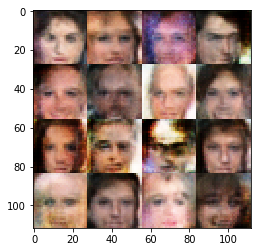

count: 5250
count: 5300
Epoch 0... Discriminator Loss: 1.4615... Generator Loss: 0.7557 Batch Duration: 0.1149
count: 5350
count: 5400
Epoch 0... Discriminator Loss: 1.4780... Generator Loss: 0.6721 Batch Duration: 0.1140


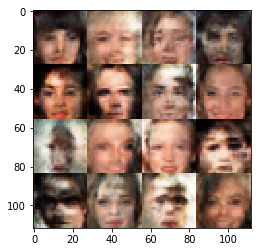

count: 5450
count: 5500
Epoch 0... Discriminator Loss: 1.4835... Generator Loss: 0.7618 Batch Duration: 0.1123
count: 5550
count: 5600
Epoch 0... Discriminator Loss: 1.4129... Generator Loss: 0.7093 Batch Duration: 0.1130


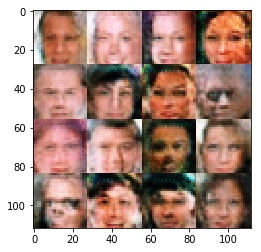

count: 5650
count: 5700
Epoch 0... Discriminator Loss: 1.3315... Generator Loss: 0.7082 Batch Duration: 0.1135
count: 5750
count: 5800
Epoch 0... Discriminator Loss: 1.4559... Generator Loss: 0.7338 Batch Duration: 0.1131


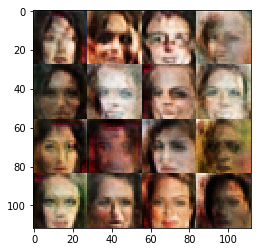

count: 5850
count: 5900
Epoch 0... Discriminator Loss: 1.3383... Generator Loss: 0.5979 Batch Duration: 0.1140
count: 5950
count: 6000
Epoch 0... Discriminator Loss: 1.4655... Generator Loss: 0.7091 Batch Duration: 0.1147


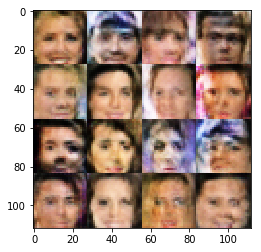

count: 6050
count: 6100
Epoch 0... Discriminator Loss: 1.3474... Generator Loss: 0.7865 Batch Duration: 0.1131
count: 6150
count: 6200
Epoch 0... Discriminator Loss: 1.3687... Generator Loss: 0.7394 Batch Duration: 0.1155


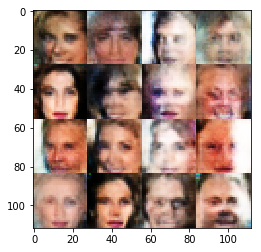

count: 6250
count: 6300
Epoch 0... Discriminator Loss: 1.4066... Generator Loss: 0.7475 Batch Duration: 0.1130
count: 6350
count: 6400
Epoch 0... Discriminator Loss: 1.3493... Generator Loss: 0.6394 Batch Duration: 0.1121


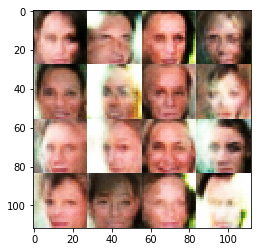

count: 6450
count: 6500
Epoch 0... Discriminator Loss: 1.3218... Generator Loss: 0.7702 Batch Duration: 0.1129
count: 6550
count: 6600
Epoch 0... Discriminator Loss: 1.3824... Generator Loss: 0.7503 Batch Duration: 0.1134


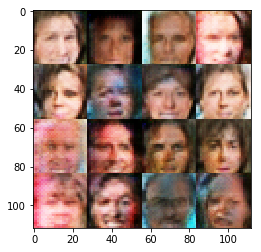

count: 6650
count: 6700
Epoch 0... Discriminator Loss: 1.3836... Generator Loss: 0.7640 Batch Duration: 0.1129
count: 6750
count: 6800
Epoch 0... Discriminator Loss: 1.4019... Generator Loss: 0.7398 Batch Duration: 0.1141


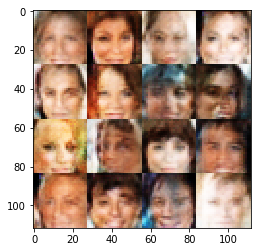

count: 6850
count: 6900
Epoch 0... Discriminator Loss: 1.4036... Generator Loss: 0.6753 Batch Duration: 0.1125
count: 6950
count: 7000
Epoch 0... Discriminator Loss: 1.3515... Generator Loss: 0.7317 Batch Duration: 0.1146


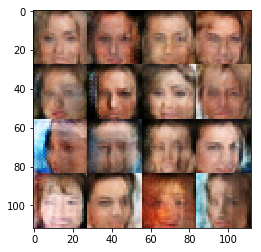

count: 7050
count: 7100
Epoch 0... Discriminator Loss: 1.4089... Generator Loss: 0.7098 Batch Duration: 0.1138
count: 7150
count: 7200
Epoch 0... Discriminator Loss: 1.4313... Generator Loss: 0.7397 Batch Duration: 0.1123


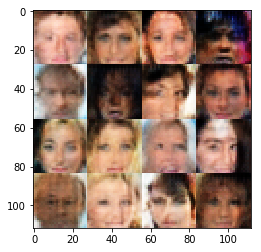

count: 7250
count: 7300
Epoch 0... Discriminator Loss: 1.3786... Generator Loss: 0.7944 Batch Duration: 0.1129
count: 7350
count: 7400
Epoch 0... Discriminator Loss: 1.4210... Generator Loss: 0.7865 Batch Duration: 0.1123


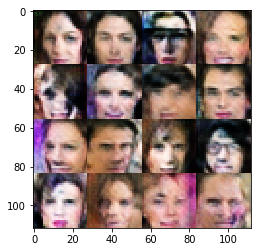

count: 7450
count: 7500
Epoch 0... Discriminator Loss: 1.3535... Generator Loss: 0.7550 Batch Duration: 0.1134
count: 7550
count: 7600
Epoch 0... Discriminator Loss: 1.3409... Generator Loss: 0.8576 Batch Duration: 0.1129


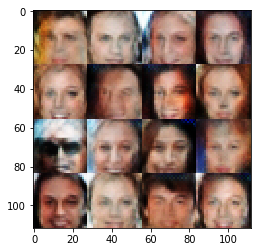

count: 7650
count: 7700
Epoch 0... Discriminator Loss: 1.4485... Generator Loss: 0.7863 Batch Duration: 0.1130
count: 7750
count: 7800
Epoch 0... Discriminator Loss: 1.3823... Generator Loss: 0.7416 Batch Duration: 0.1127


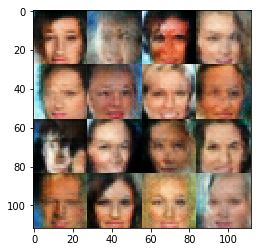

count: 7850
count: 7900
Epoch 0... Discriminator Loss: 1.3632... Generator Loss: 0.8517 Batch Duration: 0.1149
count: 7950
count: 8000
Epoch 0... Discriminator Loss: 1.3821... Generator Loss: 0.7058 Batch Duration: 0.1128


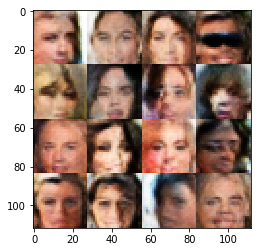

count: 8050
count: 8100
Epoch 0... Discriminator Loss: 1.3531... Generator Loss: 0.7859 Batch Duration: 0.1129
count: 8150
count: 8200
Epoch 0... Discriminator Loss: 1.2390... Generator Loss: 0.7882 Batch Duration: 0.1128


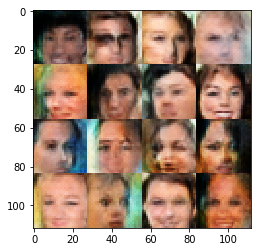

count: 8250
count: 8300
Epoch 0... Discriminator Loss: 1.3837... Generator Loss: 0.7097 Batch Duration: 0.1137
count: 8350
count: 8400
Epoch 0... Discriminator Loss: 1.3706... Generator Loss: 0.7175 Batch Duration: 0.1126


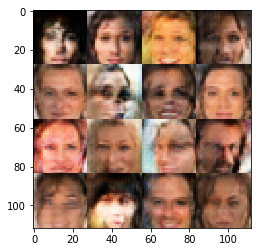

count: 8450
count: 8500
Epoch 0... Discriminator Loss: 1.3797... Generator Loss: 0.7160 Batch Duration: 0.1136
count: 8550
count: 8600
Epoch 0... Discriminator Loss: 1.3938... Generator Loss: 0.8186 Batch Duration: 0.1127


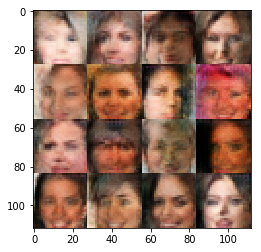

count: 8650
count: 8700
Epoch 0... Discriminator Loss: 1.3731... Generator Loss: 0.7810 Batch Duration: 0.1146
count: 8750
count: 8800
Epoch 0... Discriminator Loss: 1.3818... Generator Loss: 0.7690 Batch Duration: 0.1129


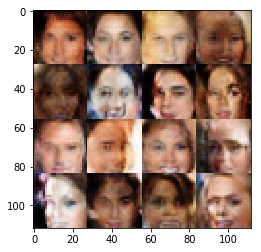

count: 8850
count: 8900
Epoch 0... Discriminator Loss: 1.3784... Generator Loss: 0.7518 Batch Duration: 0.1126
count: 8950
count: 9000
Epoch 0... Discriminator Loss: 1.3489... Generator Loss: 0.8059 Batch Duration: 0.1141


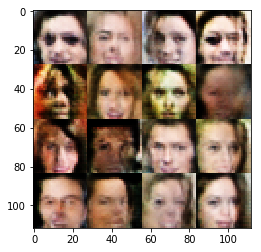

count: 9050
count: 9100
Epoch 0... Discriminator Loss: 1.3321... Generator Loss: 0.7998 Batch Duration: 0.1142
count: 9150
count: 9200
Epoch 0... Discriminator Loss: 1.4191... Generator Loss: 0.7492 Batch Duration: 0.1150


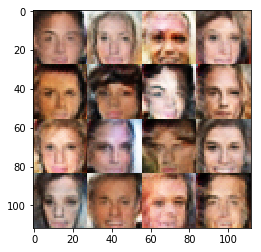

count: 9250
count: 9300
Epoch 0... Discriminator Loss: 1.3783... Generator Loss: 0.7800 Batch Duration: 0.1137
count: 9350
count: 9400
Epoch 0... Discriminator Loss: 1.3709... Generator Loss: 0.8173 Batch Duration: 0.1136


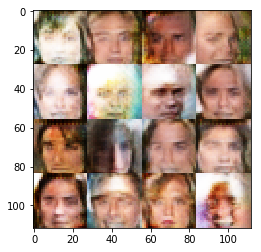

count: 9450
count: 9500
Epoch 0... Discriminator Loss: 1.4180... Generator Loss: 0.7365 Batch Duration: 0.1139
count: 9550
count: 9600
Epoch 0... Discriminator Loss: 1.3875... Generator Loss: 0.7683 Batch Duration: 0.1149


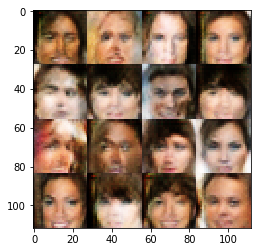

count: 9650
count: 9700
Epoch 0... Discriminator Loss: 1.3627... Generator Loss: 0.8581 Batch Duration: 0.1143
count: 9750
count: 9800
Epoch 0... Discriminator Loss: 1.3449... Generator Loss: 0.7926 Batch Duration: 0.1126


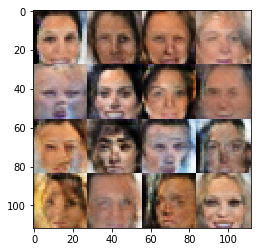

count: 9850
count: 9900
Epoch 0... Discriminator Loss: 1.4517... Generator Loss: 0.7311 Batch Duration: 0.1139
count: 9950
count: 10000
Epoch 0... Discriminator Loss: 1.4051... Generator Loss: 0.7495 Batch Duration: 0.1134


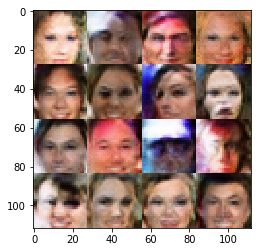

count: 10050
count: 10100
Epoch 0... Discriminator Loss: 1.3825... Generator Loss: 0.7655 Batch Duration: 0.1144
count: 10150
count: 10200
Epoch 0... Discriminator Loss: 1.3759... Generator Loss: 0.7855 Batch Duration: 0.1143


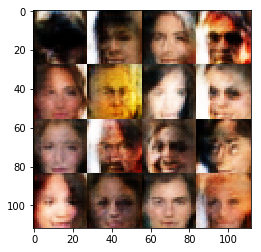

count: 10250
count: 10300
Epoch 0... Discriminator Loss: 1.4088... Generator Loss: 0.6954 Batch Duration: 0.1138
count: 10350
count: 10400
Epoch 0... Discriminator Loss: 1.3720... Generator Loss: 0.7930 Batch Duration: 0.1135


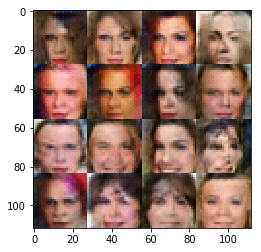

count: 10450
count: 10500
Epoch 0... Discriminator Loss: 1.3969... Generator Loss: 0.7463 Batch Duration: 0.1134
count: 10550
count: 10600
Epoch 0... Discriminator Loss: 1.3775... Generator Loss: 0.8086 Batch Duration: 0.1136


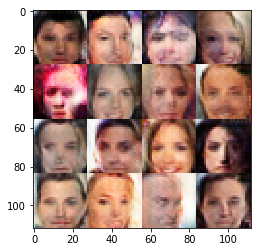

count: 10650
count: 10700
Epoch 0... Discriminator Loss: 1.3447... Generator Loss: 0.7927 Batch Duration: 0.1128
count: 10750
count: 10800
Epoch 0... Discriminator Loss: 1.3827... Generator Loss: 0.8088 Batch Duration: 0.1136


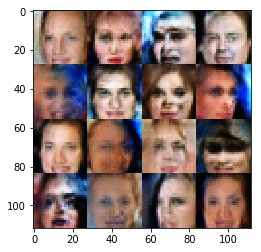

count: 10850
count: 10900
Epoch 0... Discriminator Loss: 1.4097... Generator Loss: 0.7256 Batch Duration: 0.1125
count: 10950
count: 11000
Epoch 0... Discriminator Loss: 1.3785... Generator Loss: 0.7476 Batch Duration: 0.1131


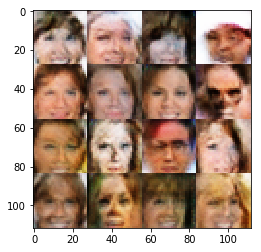

count: 11050
count: 11100
Epoch 0... Discriminator Loss: 1.3629... Generator Loss: 0.7657 Batch Duration: 0.1143
count: 11150
count: 11200
Epoch 0... Discriminator Loss: 1.4083... Generator Loss: 0.6901 Batch Duration: 0.1127


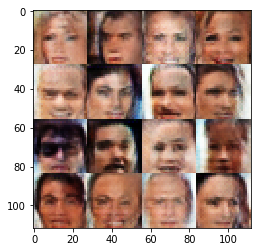

count: 11250
count: 11300
Epoch 0... Discriminator Loss: 1.4164... Generator Loss: 0.7676 Batch Duration: 0.1119
count: 11350
count: 11400
Epoch 0... Discriminator Loss: 1.4028... Generator Loss: 0.7594 Batch Duration: 0.1126


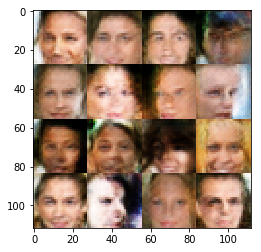

count: 11450
count: 11500
Epoch 0... Discriminator Loss: 1.3506... Generator Loss: 0.7556 Batch Duration: 0.1121
count: 11550
count: 11600
Epoch 0... Discriminator Loss: 1.3665... Generator Loss: 0.7835 Batch Duration: 0.1131


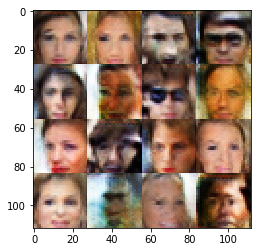

count: 11650
count: 11700
Epoch 0... Discriminator Loss: 1.3580... Generator Loss: 0.7608 Batch Duration: 0.1129
count: 11750
count: 11800
Epoch 0... Discriminator Loss: 1.3570... Generator Loss: 0.7992 Batch Duration: 0.1136


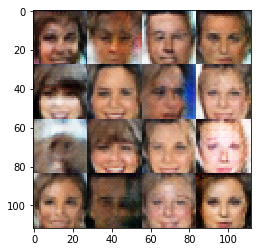

count: 11850
count: 11900
Epoch 0... Discriminator Loss: 1.3757... Generator Loss: 0.8171 Batch Duration: 0.1123
count: 11950
count: 12000
Epoch 0... Discriminator Loss: 1.3592... Generator Loss: 0.8258 Batch Duration: 0.1122


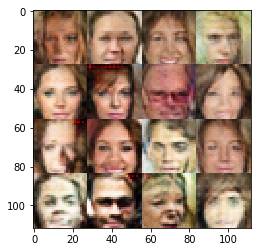

count: 12050
count: 12100
Epoch 0... Discriminator Loss: 1.3597... Generator Loss: 0.8059 Batch Duration: 0.1129
count: 12150
count: 12200
Epoch 0... Discriminator Loss: 1.3812... Generator Loss: 0.8029 Batch Duration: 0.1126


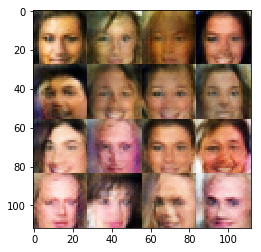

count: 12250
count: 12300
Epoch 0... Discriminator Loss: 1.3515... Generator Loss: 0.8497 Batch Duration: 0.1125
count: 12350
count: 12400
Epoch 0... Discriminator Loss: 1.3949... Generator Loss: 0.7214 Batch Duration: 0.1131


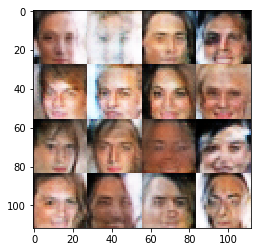

count: 12450
count: 12500
Epoch 0... Discriminator Loss: 1.3838... Generator Loss: 0.7562 Batch Duration: 0.1134
count: 12550
count: 12600
Epoch 0... Discriminator Loss: 1.3691... Generator Loss: 0.7612 Batch Duration: 0.1140


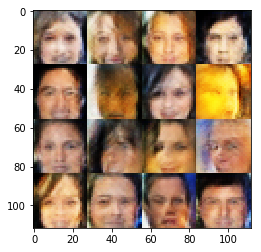

count: 12650
Total Duration: 1424.8729


In [13]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005 
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.